In [98]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [99]:
def f(x):
    return 3*x**2 - 4*x + 5

In [100]:
f(3)

20

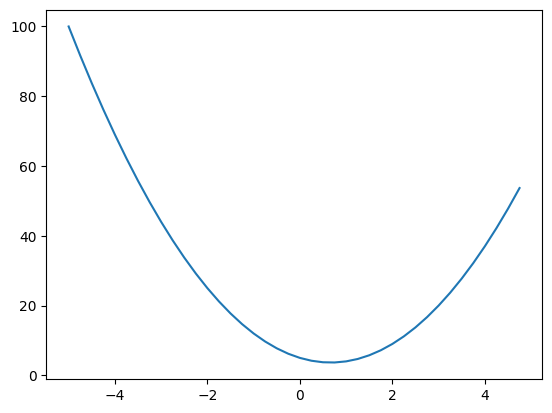

In [101]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [102]:
h = 0.000001
x = -3
(f(x+h) - f(x))/h # how much f(x) changes when x changes by h

-21.999997002808414

In [103]:
a = 2.0
b = -3.0


c = 10.0
d = a*b + c
print(d)

4.0


In [104]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0


d1 = a*b + c
a += h
d2 = a*b + c


print(d1, 'd1')
print(d2, 'd2')
print((d2-d1)/h, 'd2-d1/h - slope')



4.0 d1
3.999699999999999 d2
-3.000000000010772 d2-d1/h - slope


In [105]:
h = 0.0001

a = 2.0
b = -3.0
c = 10.0


d1 = a*b + c
c += h
d2 = a*b + c


print(d1, 'd1')
print(d2, 'd2')
print((d2-d1)/h, 'd2-d1/h - slope')


4.0 d1
4.0001 d2
0.9999999999976694 d2-d1/h - slope


In [106]:
class Value:

    def __init__(self, data, _childern=(), _op= "", label= ""):
        self.data = data
        self.grad = 0
        self._backward = lambda: None
        self._prev = set(_childern)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"value(data = {self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int or float"
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other): # other * self
        return self * other # 2 * a = a * 2
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other) # a - b = a + (-b)
    
    def __radd__(self, other): # other + self
        return self + other # 2 + a = a + 2

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
        out = Value(t, (self,), "tanh")
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data 
        out = Value(math.exp(x), (self,), "exp")

        def _backward():
            self.grad += out.data * out.grad # d(e^x)/dx = e^x
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    

a= Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

value(data = -8.0)

In [107]:
a = Value(2.0)
b = Value(4.0)
a - b

value(data = -2.0)

In [108]:
# Visualize the function as a graph
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{  %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad ), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

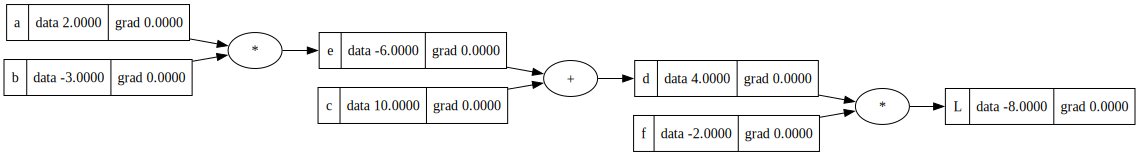

In [109]:
draw_dot(L)

In [110]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-36.0


In [111]:
def lol():
  
  h = 0.001
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  
  f = Value(-2.0, label='f')
  f.data += h
  L = d * f; L.label = 'L'
  L2 = L.data
  
  print((L2 - L1)/h)
  
lol()

3.9999999999995595


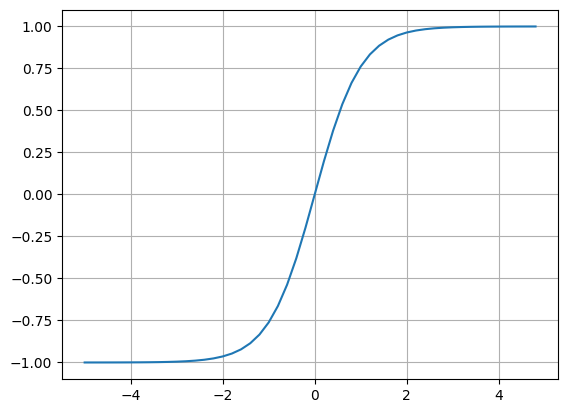

In [112]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [113]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

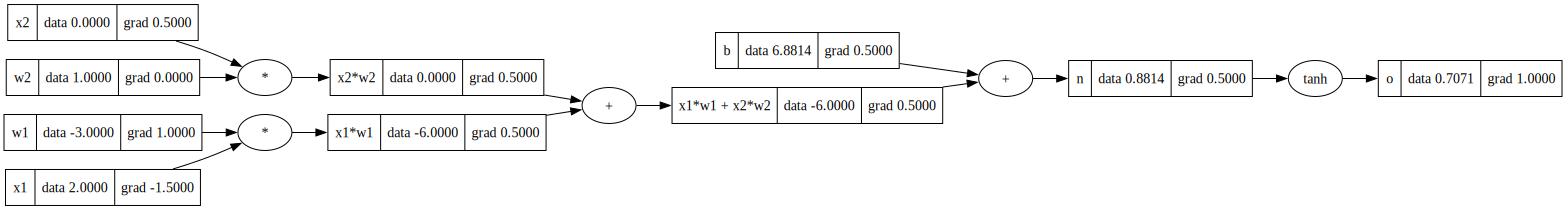

In [114]:
draw_dot(o)

In [115]:
o.grad = 1.0
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo



[value(data = 0.0),
 value(data = 1.0),
 value(data = 0.0),
 value(data = 2.0),
 value(data = -3.0),
 value(data = -6.0),
 value(data = -6.0),
 value(data = 6.881373587019543),
 value(data = 0.8813735870195432),
 value(data = 0.7071067811865476)]

In [116]:

for node in reversed(topo):
  node._backward()
  

In [117]:
o.grad = 1.0


In [118]:
o._backward()

In [119]:
n._backward()

In [120]:
b._backward()

In [121]:
x1w1x2w2._backward()

In [122]:
x1w1._backward()
x2w2._backward()

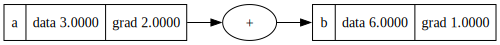

In [123]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

In [124]:
# break tanh into formulae
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e -1) / (e + 1)

o.backward()

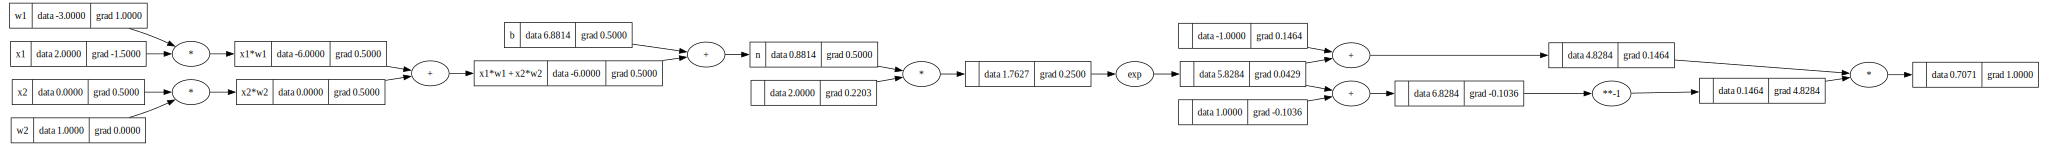

In [125]:
draw_dot(o)

## EXACT SAME THING USING PYTORCH

In [126]:
import torch

In [127]:
x1 = torch.tensor([2.0]).double(); x1.requires_grad = True
x2 = torch.tensor([0.0]).double(); x2.requires_grad = True
w1 = torch.tensor([-3.0]).double(); w1.requires_grad = True
w2 = torch.tensor([1.0]).double(); w2.requires_grad = True  
b = torch.tensor([6.8813735870195432]).double(); b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()    

print("w1.grad", w1.grad.item())
print("w2.grad", w2.grad.item())
print("b.grad", b.grad.item())
print("x1.grad", x1.grad.item())
print("x2.grad", x2.grad.item())

0.7071066904050358
w1.grad 1.0000002567688737
w2.grad 0.0
b.grad 0.5000001283844369
x1.grad -1.5000003851533106
x2.grad 0.5000001283844369


In [128]:
# match the above with neural network.
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        # print(list(zip(self.w, x)))
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]   

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons] 
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        # print(sz)
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        # print([i.__getattribute__ for i in self.layers])

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
        


In [129]:

x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

value(data = -0.8518052912670893)

In [130]:
n.parameters()

[value(data = -0.4853120395034183),
 value(data = -0.32825196616580987),
 value(data = 0.4441144828334953),
 value(data = 0.8969238070472225),
 value(data = 0.47453553675833215),
 value(data = -0.23781653748323617),
 value(data = 0.5621213011721644),
 value(data = -0.8664519562872677),
 value(data = -0.4564689650222329),
 value(data = 0.41267445523036694),
 value(data = 0.9048962840144357),
 value(data = -0.36530225107735803),
 value(data = 0.5709906454577482),
 value(data = -0.845153090709613),
 value(data = -0.1042194803295784),
 value(data = -0.23926061544422184),
 value(data = 0.2873200234417552),
 value(data = -0.24156822146561985),
 value(data = 0.21528555282741113),
 value(data = -0.13295987362613837),
 value(data = 0.20967943649130216),
 value(data = -0.3211883219549616),
 value(data = -0.630380927230745),
 value(data = 0.9107645090073244),
 value(data = 0.7561816506743779),
 value(data = -0.917849367109705),
 value(data = 0.8991037142483391),
 value(data = -0.9857232987050808)

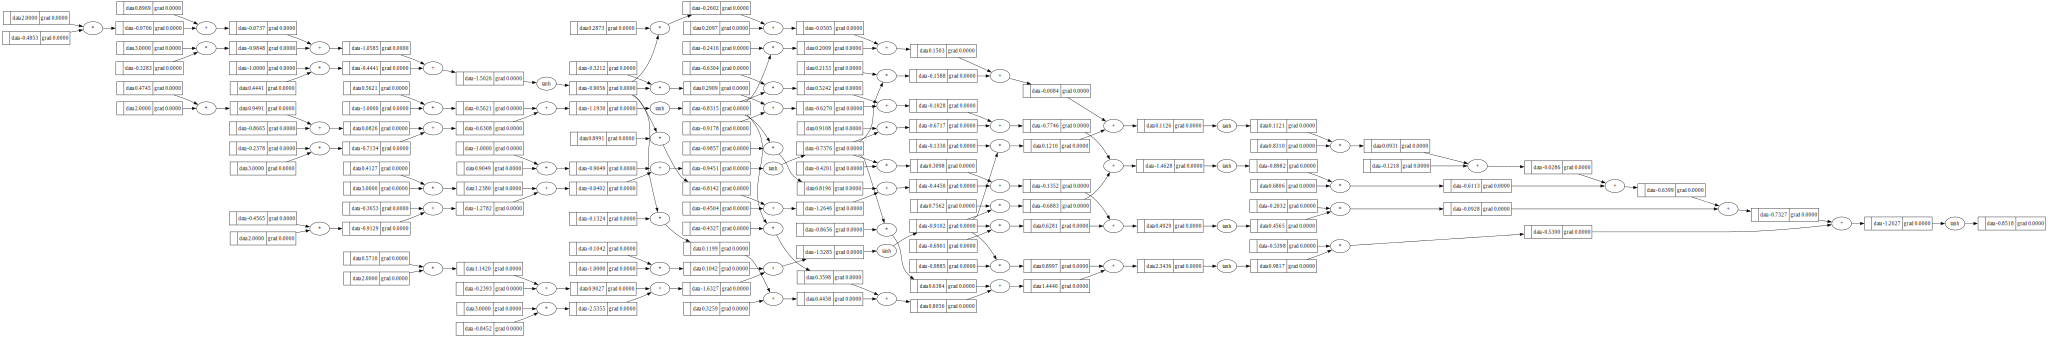

In [131]:
draw_dot(n(x))

In [132]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [133]:

for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)
  

0 7.2404124983879825
1 4.9325988849092814
2 3.0836651943703335
3 1.788742738960755
4 0.6350296086818272
5 0.2644789981446499
6 0.1406878887691422
7 0.10178373734531168
8 0.07927001009869937
9 0.0646435765689361
10 0.054407897569588394
11 0.046861749154659675
12 0.04107924421520151
13 0.03651396991819452
14 0.032823016465105506
15 0.02978052374834569
16 0.02723179752638695
17 0.025067409992624124
18 0.023207825340989904
19 0.021593881538474025


In [134]:
ypred = [n(x) for x in xs]
ypred

[value(data = 0.9440255246331491),
 value(data = -0.9447365485864668),
 value(data = -0.9191082294530218),
 value(data = 0.913686533423527)]

In [135]:
loss = sum((yout - ygrt)**2 for ygrt, yout in zip(ys, ypred))
loss

value(data = 0.020180684009403017)

In [136]:
ypred = [n(x) for x in xs]
loss = sum((yout - ygrt)**2 for ygrt, yout in zip(ys, ypred))
loss

value(data = 0.020180684009403017)

In [137]:
loss.backward()

In [138]:
n.layers[0].neurons[0].w[0].data

-0.49411345815371394

In [139]:
for p in n.parameters():
    p.data += -0.01 * p.grad


In [140]:
n.layers[0].neurons[0].w[0].data

-0.4939988806630151

In [141]:
ypred

[value(data = 0.9440255246331491),
 value(data = -0.9447365485864668),
 value(data = -0.9191082294530218),
 value(data = 0.913686533423527)]

In [142]:
n.parameters()

[value(data = -0.4939988806630151),
 value(data = -0.36806526032063924),
 value(data = 0.5615326193071473),
 value(data = 0.8970366894833395),
 value(data = 0.5480998390399711),
 value(data = -0.17679937695374842),
 value(data = 1.1392673127964856),
 value(data = -0.5880810416113855),
 value(data = -0.2629304376433154),
 value(data = 0.677335107121578),
 value(data = 0.6978302988191153),
 value(data = -0.2854066938981606),
 value(data = 0.652577050305994),
 value(data = -0.7412715802512996),
 value(data = -0.13325326564773832),
 value(data = -0.15692150396865343),
 value(data = -0.4356779075351825),
 value(data = -0.9522157263043897),
 value(data = -0.3477118589087434),
 value(data = -0.3011985963334247),
 value(data = 0.05662872338911269),
 value(data = -0.607581528197817),
 value(data = -0.8965398524876371),
 value(data = 0.6889903264413679),
 value(data = 0.6567674793329981),
 value(data = -0.7582481295908182),
 value(data = 0.8989976773445953),
 value(data = -0.9824024590299193),
 